# Import

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil
from typing import Tuple
import torch
import torch.nn as nn
from torchvision import models

In [2]:
import windows_utils_hf as util
import helpers

In [3]:
from sklearn import model_selection, metrics
import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

from torchvision.transforms import v2
from torchvision.io import read_image

# Load Data

In [5]:
repo_fp = Path('../data/')
noh_fp = repo_fp / 'NOH'

## NOH Data

In [6]:
noh_data = pd.read_csv('../metadata/image_dataset_v2.csv', index_col=0)
noh_data = noh_data[noh_data['data']=='NOH'].reset_index(drop=True)
noh_data

,data,patient_id,img_id,label,dataset,img_path,filename,new_img_path
0,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082014.jpg,processed_img/NOH_122/IMG_20230228_082014.jpg
1,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082225.jpg,processed_img/NOH_122/IMG_20230228_082225.jpg
2,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082229.jpg,processed_img/NOH_122/IMG_20230228_082229.jpg
3,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_081641.jpg,processed_img/NOH_122/IMG_20230228_081641.jpg
4,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082243.jpg,processed_img/NOH_122/IMG_20230228_082243.jpg
...,...,...,...,...,...,...,...,...
2043,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082639.jpg,processed_img/NOH_24/IMG_20230116_082639.jpg
2044,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082508.jpg,processed_img/NOH_24/IMG_20230116_082508.jpg
2045,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082541.jpg,processed_img/NOH_24/IMG_20230116_082541.jpg
2046,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082615.jpg,processed_img/NOH_24/IMG_20230116_082615.jpg


# Stats

In [7]:
noh_data[['label']].value_counts().sort_index()

label
0         97
1        179
2        106
3         89
4        789
5        788
Name: count, dtype: int64

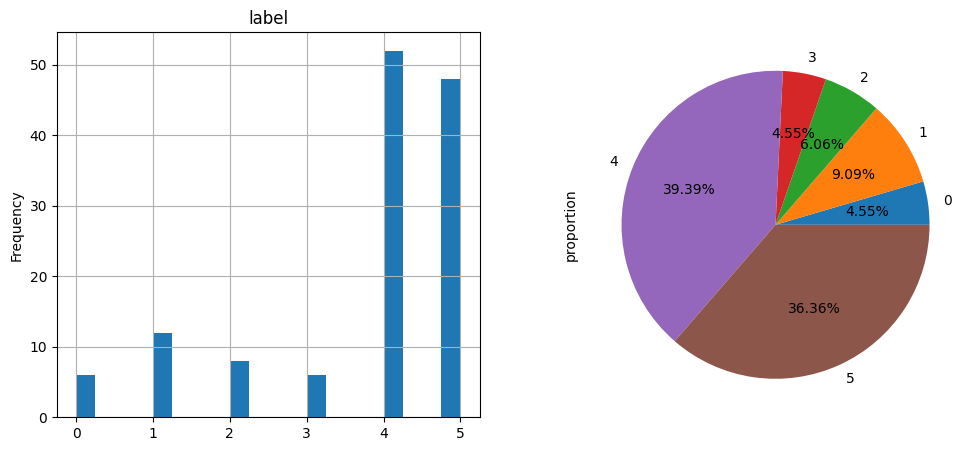

In [8]:
noh_sum = noh_data[['patient_id', 'label']].drop_duplicates()
fig, axs = plt.subplots(1,2,figsize=(12,5))
noh_sum['label'].plot(kind='hist', bins=20, title='label',ax=axs[0], grid=True)
noh_sum['label'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

## Per patient

In [9]:
noh_data.groupby(['dataset','label'])['patient_id'].nunique().to_frame().reset_index().pivot_table(index='dataset', columns='label', values='patient_id').astype(int)

label,0,1,2,3,4,5
dataset,,,,,,
test,2,3,2,1,15,16
train,2,5,4,2,22,21
val,2,4,2,3,15,11


## Per Image

In [10]:
noh_data.groupby(['dataset','label'])['filename'].nunique().to_frame().reset_index().pivot_table(index='dataset', columns='label', values='filename').astype(int)

label,0,1,2,3,4,5
dataset,,,,,,
test,35,45,24,13,260,267
train,27,77,54,27,311,335
val,35,57,28,49,218,186


In [11]:
img_ds = noh_data[['new_img_path', 'label', 'dataset']]
img_ds = img_ds.rename(columns={'new_img_path': 'img_path'})
img_ds['img_path'] = img_ds['img_path'].apply(lambda x: os.path.join(str(repo_fp), x.replace('./','')))
img_ds

,img_path,label,dataset
0,../data/processed_img/NOH_122/IMG_20230228_082...,4,train
1,../data/processed_img/NOH_122/IMG_20230228_082...,4,train
2,../data/processed_img/NOH_122/IMG_20230228_082...,4,train
3,../data/processed_img/NOH_122/IMG_20230228_081...,4,train
4,../data/processed_img/NOH_122/IMG_20230228_082...,4,train
...,...,...,...
2043,../data/processed_img/NOH_24/IMG_20230116_0826...,5,test
2044,../data/processed_img/NOH_24/IMG_20230116_0825...,5,test
2045,../data/processed_img/NOH_24/IMG_20230116_0825...,5,test
2046,../data/processed_img/NOH_24/IMG_20230116_0826...,5,test


## Transform

In [12]:
plt.rcParams["savefig.bbox"] = 'tight'

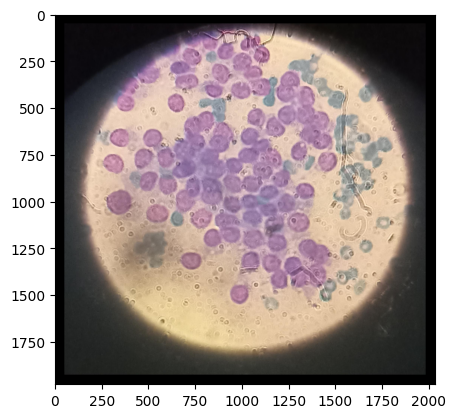

In [13]:
img_path = img_ds.iloc[0]['img_path']
# img = read_image(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [14]:
# prompt: generate train and test transform


# Create transforms for train and test data
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.RandomCrop(224),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10), # [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Inspect train and test transform

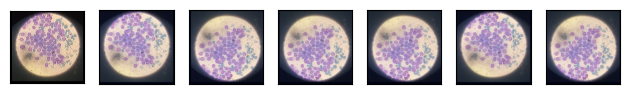

In [15]:
train_outs = [train_transform(img) for i in range(5)]
test_out = test_transform(img)
helpers.plot([img, test_out] + train_outs)

## Batch size

In [16]:
batch_size=32

# Dataset and DataLoader

In [17]:
# prompt: i need pytorch dataset that read from dataframe
class ThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['img_path'][idx]
        label = self.dataframe['label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [18]:
train_df = img_ds[img_ds['dataset']=='train'].reset_index(drop=True)
val_df = img_ds[img_ds['dataset']=='val'].reset_index(drop=True)
test_df = img_ds[img_ds['dataset']=='test'].reset_index(drop=True)

In [19]:
trainset = ThyroidDataset(train_df, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [20]:
valset = ThyroidDataset(val_df, transform=test_transform)
valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

In [21]:
testset = ThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

##  Inspect Image

In [22]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

../data/processed_img/NOH_111/IMG_20230224_104330.jpg


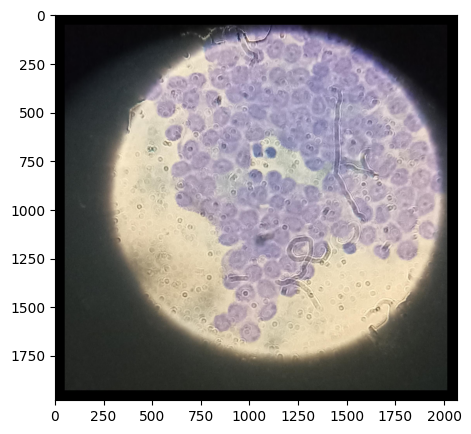

In [23]:
# Select a random item from the dataset
import numpy as np
item_path = np.random.choice(train_df['img_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


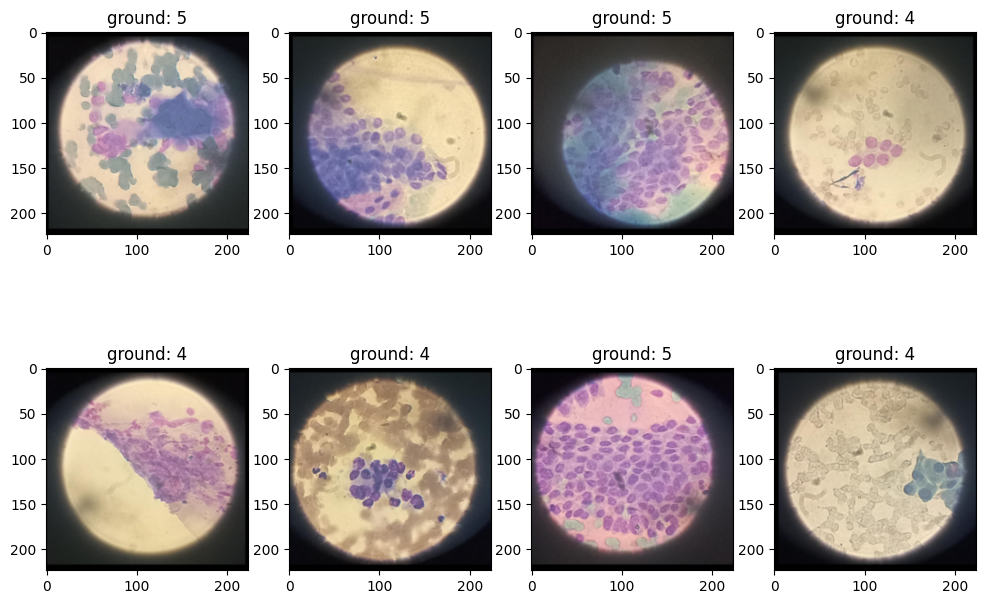

In [24]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1
#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Device and Tensorboard

In [25]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")


Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB

GPU 1: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB



In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
# prompt: use tensorboard to log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../runs/thyroid_noh_vgg11tf')

2024-02-15 15:58:09.543591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 15:58:09.543622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 15:58:09.544698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 15:58:09.550864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 15:58:10.356527: W tensorflow/comp

# Load model

In [28]:
class VGG11Model(nn.Module):
    """VGG11 model class.

    Attributes:
        biases (torch.nn.Parameter): TODO: add description.
        vgg_features (torch.nn.Module): VGG feature map function.
        features (torch.nn.Sequential): hidden layers.
        classifier (torch.nn.Sequential): classifier.
    """
    def __init__(self):
        """VGG11 model class constructor. 
        
        Args:
            params (dict): hyperparameters.
        """
        super(VGG11Model, self).__init__()
        
        # Reload VGG1 pretrained model
        vgg11 = models.vgg11_bn(pretrained=1)
        vgg_checkpoint = torch.load('../repo/DavidDov/tele_cyto_models/hub/checkpoints/vgg11_bn-6002323d.pth')
        vgg11.load_state_dict(vgg_checkpoint)
        
        # Define VGG11 feature extractor.
        self.vgg_features = vgg11.features        
        # Further feature extraction.
        self.features = nn.Sequential(
            nn.Linear(512 * 7 * 7 , 16),
            nn.BatchNorm1d(16),
            nn.ReLU(True))
        
        # Final classifier. 
        self.classifier = nn.Sequential( 
            nn.BatchNorm1d(16), #nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(16, 6))
        
               
    def forward(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """VGG11 classifier forward pass.

        Args:
            z (torch.Tensor): [B, C, H, W] torch.tensor input. (B=batch, CHW=image dims).

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: _description_
        """
        # Extract VGG features: [B, C, H, W] -> [B, 512, 7, 7].
        z = self.vgg_features(z)     
        # print(z.shape)
        # Reshape: [B, 512, 7, 7] -> [B, 512*7*7=25088]
        z = z.view(z.shape[0], -1)  
        # print(z.shape)
        # Further feature extraction: [B, 512*7*7] -> [B, 16].
        z = self.features(z)
        # print(z.shape)
        z = self.classifier(z)
        # print(z.shape)
        return z
    
    def turn_train(self):
        self.vgg_features.grad = True
        self.features.grad = True
        self.classifier.grad = True
        
    def turn_eval(self):
        self.vgg_features.grad = False
        self.features.grad = False
        self.classifier.grad = False

In [29]:
model = VGG11Model()

/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Test Input to VGG model

In [30]:
image = Image.open('/home/quan/work/thyroid/data/NOH/001.NguyeThiLan- Right/IMG_20221219_101351.jpg')
image = test_transform(image)
print(image.shape)
image = image.unsqueeze(0)
print(image.shape)
# image = image.to(device)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [31]:
# output = model(image)

In [32]:
# model._fc = nn.Linear(model._fc.in_features, train_df['label'].nunique())
model.to(device);

In [33]:
model.classifier

Sequential(
  (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=16, out_features=6, bias=True)
)

In [34]:
num_epochs = 20
best_val_acc = 0.0

# Criterion, Optimizer, Scheduler

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

In [36]:
# AdamW optimizer; includes weight decay for regularization
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=num_epochs*len(trainloader))

In [37]:
def evaluate_dataset(model, ds_loader):
    model.turn_eval()
    loss = 0.0
    acc = 0.0
    for _, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    loss /= len(testloader)
    acc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    return acc

# If exist model, then evaluate before write new

In [38]:
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2,3,4,5]
    with torch.no_grad():
        preds = model(test_features.to(device))
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

In [39]:
baseline_model_path = '../model/noh/vgg1_tf.pt'

  0%|          | 0/18 [00:00<?, ?it/s]

Test Loss: 0.3578 	Test Acc: 0.3384
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Label:  5
Predicted:  5
Label:  5
Predicted:  4
Label:  5
Predicted:  5
Label:  5
Predicted:  5
Label:  5
Predicted:  5
Label:  5
Predicted:  4
Label:  5
Predicted:  5
Label:  5
Predicted:  5
Label:  5
Predicted:  4


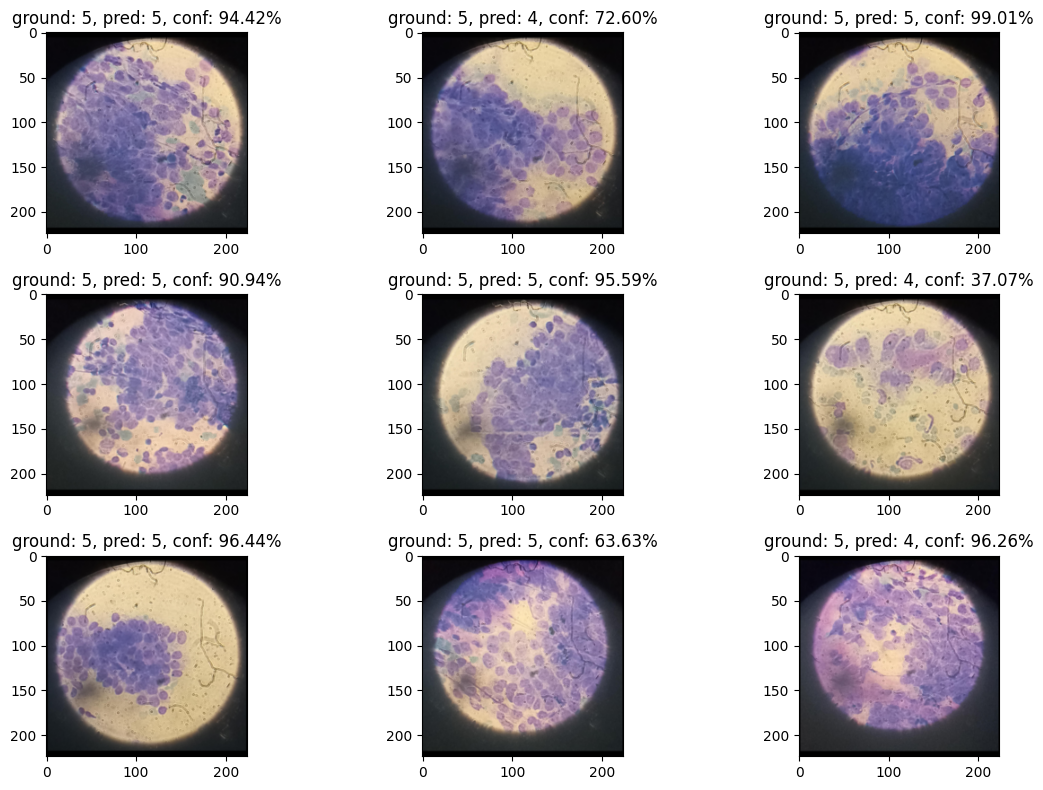

In [40]:
# reload model
model_fp = Path(baseline_model_path)
if model_fp.exists():
    model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
    best_val_acc = evaluate_dataset(model, valoader)
    run_predict_testset()

In [41]:
best_val_acc

0.3384133825944171

# Train model

In [42]:
# for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#     data, target = data.to(device), target.to(device)

In [43]:
# for batch_idx, (data, target) in enumerate(tqdm(valoader)):
#     data, target = data.to(device), target.to(device)

In [44]:
# for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#     data, target = data.to(device), target.to(device)

In [45]:
for epoch in range(num_epochs):
    model.turn_train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    model.turn_eval()
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(valoader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    val_loss /= len(valoader)
    val_acc /= len(valoader)

    scheduler.step(val_loss)

    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc))
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(valoader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(valoader) + batch_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), baseline_model_path)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0 	Train Loss: 0.4601 	Train Acc: 0.8545 	Val Loss: 2.4702 	Val Acc: 0.3582


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [02:00<?, ?it/s]

Epoch: 1 	Train Loss: 0.3900 	Train Acc: 0.8713 	Val Loss: 2.4610 	Val Acc: 0.3335


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 	Train Loss: 0.3988 	Train Acc: 0.8531 	Val Loss: 2.3374 	Val Acc: 0.3610


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3 	Train Loss: 0.3471 	Train Acc: 0.8928 	Val Loss: 2.5223 	Val Acc: 0.3493


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4 	Train Loss: 0.3534 	Train Acc: 0.8917 	Val Loss: 2.5045 	Val Acc: 0.3566


  0%|          | 0/26 [04:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5 	Train Loss: 0.3136 	Train Acc: 0.8941 	Val Loss: 2.6996 	Val Acc: 0.3512


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 3.0000e-04.
Epoch: 6 	Train Loss: 0.2793 	Train Acc: 0.8989 	Val Loss: 2.5896 	Val Acc: 0.3672


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7 	Train Loss: 0.2013 	Train Acc: 0.9338 	Val Loss: 2.5781 	Val Acc: 0.3764


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8 	Train Loss: 0.1879 	Train Acc: 0.9349 	Val Loss: 2.6836 	Val Acc: 0.3722


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9 	Train Loss: 0.1657 	Train Acc: 0.9447 	Val Loss: 2.6851 	Val Acc: 0.3775


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 9.0000e-05.
Epoch: 10 	Train Loss: 0.1499 	Train Acc: 0.9555 	Val Loss: 2.7086 	Val Acc: 0.3603


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [04:00<?, ?it/s]

Epoch: 11 	Train Loss: 0.1406 	Train Acc: 0.9567 	Val Loss: 2.7385 	Val Acc: 0.3690


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 12 	Train Loss: 0.1529 	Train Acc: 0.9531 	Val Loss: 2.7468 	Val Acc: 0.3618


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 13 	Train Loss: 0.1316 	Train Acc: 0.9555 	Val Loss: 2.7395 	Val Acc: 0.3688


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 2.7000e-05.
Epoch: 14 	Train Loss: 0.1295 	Train Acc: 0.9615 	Val Loss: 2.7836 	Val Acc: 0.3688


  0%|          | 0/26 [04:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15 	Train Loss: 0.1258 	Train Acc: 0.9651 	Val Loss: 2.7847 	Val Acc: 0.3653


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 16 	Train Loss: 0.1219 	Train Acc: 0.9663 	Val Loss: 2.7674 	Val Acc: 0.3653


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 17 	Train Loss: 0.1210 	Train Acc: 0.9603 	Val Loss: 2.7631 	Val Acc: 0.3636


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [04:00<?, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 8.1000e-06.
Epoch: 18 	Train Loss: 0.1307 	Train Acc: 0.9663 	Val Loss: 2.7657 	Val Acc: 0.3618


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 19 	Train Loss: 0.1205 	Train Acc: 0.9699 	Val Loss: 2.7647 	Val Acc: 0.3601


In [46]:
best_val_acc

0.37745450191570884

# Evaluate

In [47]:
evaluate_dataset(model, testloader)

  0%|          | 0/21 [00:00<?, ?it/s]

Test Loss: 0.1548 	Test Acc: 0.4003


0.40029761904761907